In [1]:
import alignment.helper
import alignment
import numpy as np
from glob import glob
import regex as re
import matplotlib.pyplot as plt
%matplotlib inline

Use this example if:
 - The cameras are stationary,
 - The code(s) move between different photos.

In the first part of the code, we build a list of lists of the filenames of each camera's photos, handle getting the times the photos were taken (so we can match up which photos are of the tag in the same location).

The QR code is assumed to be stationary within each 'interval', so we expect that two photos, taken by two cameras within interval_length are of a code in the same location.
        
interval_length: how long an interval is (in seconds), default = 1
        

In [2]:
#this is code specific to this dataset:

#a helper function specific for this dataset that gets the time from the filename
def getsecondsfromfn(fn):
    """Get number of seconds since midnight from filename, returns float"""
    timestring = re.findall('([0-9]{2}:[0-9]{2}:[0-9]{2}.[0-9]{6})',fn)[0]
    hours,mins,secs = [float(st) for st in timestring.split(':')]
    return hours*3600+mins*60+secs

#getting the image filenames
paths = ['demo_sametag/cam1','demo_sametag/cam2']
allimgfiles = [sorted(glob(path+'/*.np'))[:8] for path in paths]
del allimgfiles[0][4]

#compute the start times of intervals
alltimes = []
for imgfiles in allimgfiles:
    for fn in imgfiles:
        alltimes.append(getsecondsfromfn(fn))

#get the interval start times
intervalstarts = alignment.helper.getintervalstarts(alltimes,interval_length=1)

allimages = []
allintervals = []
#loop through the cameras...
for imgi,imgfiles in enumerate(allimgfiles):
    images = []
    intervals = []
    #loop through our images...
    for fn in imgfiles:
        interval = alignment.helper.getinterval(getsecondsfromfn(fn),intervalstarts)
        data = np.load(fn,allow_pickle=True)
        images.append(data['img'].astype(float))
        intervals.append(interval)
    allimages.append(images)
    allintervals.append(intervals)

In [3]:
allintervals

[[0, 1, 2, 3, 5, 6, 7], [0, 1, 2, 3, 4, 5, 6, 7]]

In [4]:
al = alignment.build_alignment_object(allimages,allintervals)
alignment.helper.addmissingobs_timeinterval(al.photos) 

In [5]:
al.compute_orientation()

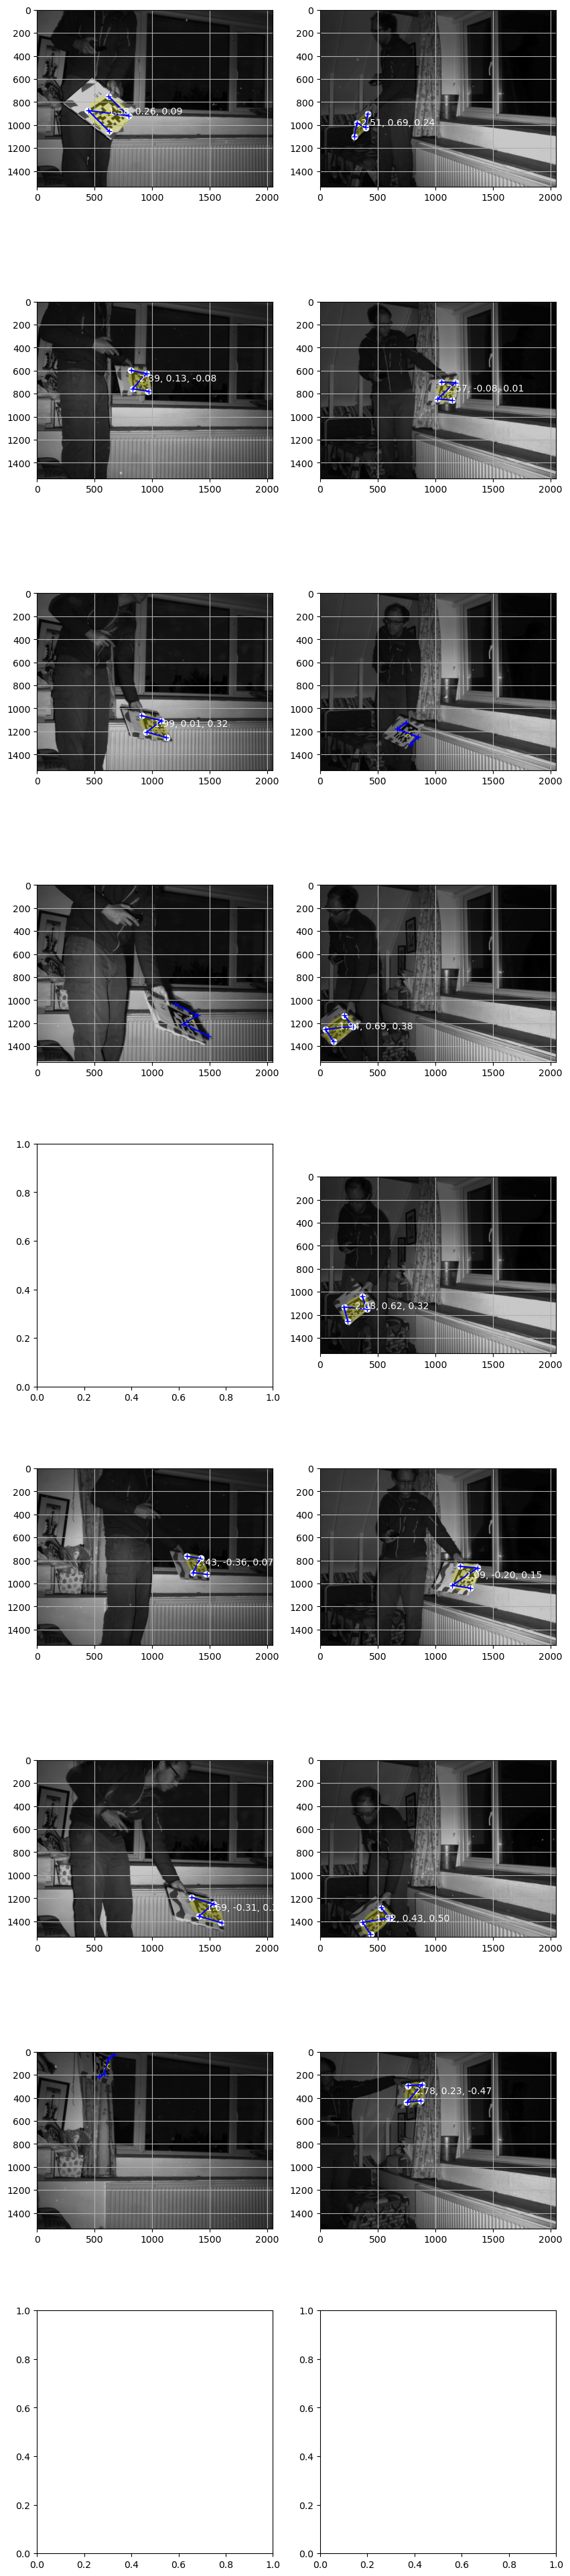

In [6]:
plt.figure(figsize=[10,50])
for i in range(len(intervalstarts)):
    for j in range(len(al.cameras)):
        plt.subplot(len(intervalstarts),len(al.cameras),i*len(al.cameras)+j+1)
        for photo in al.photos:
            if photo.camera == al.cameras[j]:
                if photo.timeindex == i:                
                    photo.draw()
                    plt.xlim([0,2048])
                    plt.ylim([1536,0]) 
                    plt.grid()

In [37]:
c = al.cameras[1]

In [54]:
from scipy.spatial.transform import Rotation as R
def get_pixel_local_vector(self,pixel_position):
    """
    Given a pixel coordinate, what equivalent vector does this correspond to?
    
    TODO Add a test:
            vec = c.get_pixel_local_vector(np.array([123.0,456]))*100+c.loc
            c.get_pixel_loc(vec)
    will return 123,456
    """
    #local_vector = [1,?,?]
    local_vector = np.array([0.0,0,0])
    local_vector[0] = 1.0
    local_vector[1] = -(self.hfov/self.res[0])*(pixel_position[0] - self.res[0]/2)
    local_vector[2] = -(self.vfov/self.res[1])*(pixel_position[1] - self.res[1]/2)

    r1 = R.from_euler('z', -self.orientation[0], degrees=False) #yaw
    r2 = R.from_euler('Y', -self.orientation[1], degrees=False) #pitch (intrinsic rotation around y axis)    
    r3 = R.from_euler('X', -self.orientation[2], degrees=False) #roll (intrinsic rotation around x axis)    
    pvec = r1.apply(r2.apply(r3.apply(local_vector)))

    #p = np.array(pvec + self.loc)        
    pvec/=np.sqrt(np.sum(pvec**2))
    return pvec

In [55]:
get_pixel_local_vector(c,np.array([123.0,456]))

array([-0.15479095,  0.98371951,  0.09129999])

In [57]:
vec = get_pixel_local_vector(c,np.array([123.0,456]))*100+c.loc
c.get_pixel_loc(vec)

array([[123., 456.]])